# Levantar datos

En lo siguiente, el día 1 corresponde al 22.01.2020, el día 11 
al 01.02.2020, el día 39 al 01.03.2020, el día 62 al 01.04.2020 
y el día 101 al 01.05.2020


## Curvas en Argentina

La actualización de estos datos es manual, por lo que sólo se actualizan cada cierto tiempo, de acuerdo a los reportes del ministerio de salud.

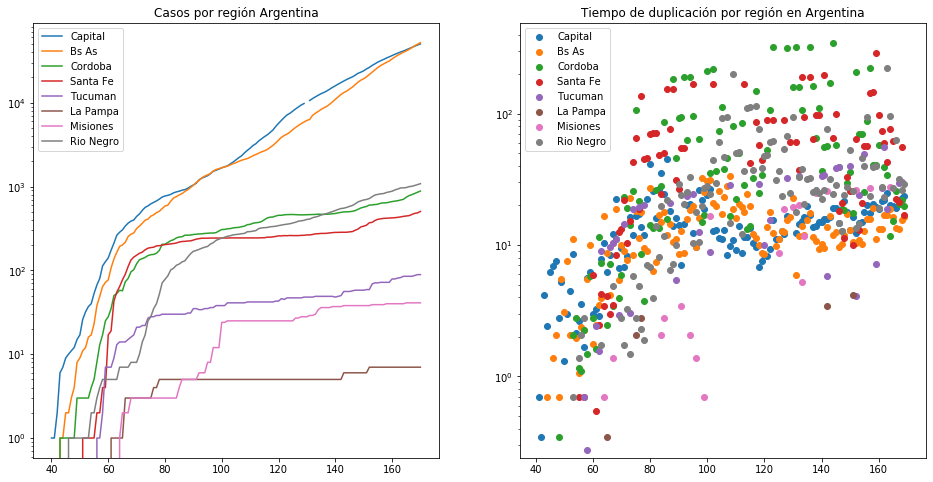

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas


datosar = pandas.read_csv("data/casosar.csv")

fig, axs = plt.subplots(1,2,figsize=(16,8))
ax = axs[0]
for region in ("Capital","Bs As", "Cordoba","Santa Fe","Tucuman", "La Pampa","Misiones","Rio Negro"):
    infectados = datosar[region].to_numpy()
    nuevos = infectados[1:]-infectados[:-1] 
    dias=np.array(range(len(infectados)))+40
    ax.plot(dias,infectados,label=region)

ax.set_title("Casos por región Argentina")
ax.set_yscale("log")
ax.legend()

ax= axs[1]

for region in ("Capital","Bs As", "Cordoba","Santa Fe","Tucuman", "La Pampa","Misiones","Rio Negro"):
    infectados = datosar[region].to_numpy()
    nuevos = infectados[1:]-infectados[:-1] 
    dias=np.array(range(len(nuevos)))+40
    ax.scatter(dias,np.log(2)/(nuevos/infectados[:-1]),label=region)

ax.set_title("Tiempo de duplicación por región en Argentina")
ax.set_yscale("log")
ax.legend()



# Levantar Datos a nivel mundial (Fuente: John Hopkings University)

In [2]:
from IPython.display import HTML
import pandas
import json
import numpy as np


data_source="https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename="
data_infected_by_region =   pandas.read_csv("https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv")
data_recovered_by_region =  pandas.read_csv("https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv")
data_deaths_by_region =     pandas.read_csv("https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv")

populations = pandas.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
populations[populations["Country Name"]=="United States"]
populations=populations.append({"Country Name":"US","Country Code":"USA", "Year":2020,"Value":323127513.},ignore_index=True )
populations=populations.append({"Country Name":"Korea, South","Country Code":"SKorea", "Year":2020,"Value":51606633},ignore_index=True )


import matplotlib.pyplot as plt

countries={"New Zealand","Russia","Kenya","Congo (Kinshasa)","Egypt","Madagascar","South Africa","Ethiopia","Australia","India","Korea, South","Finland","Norway","Argentina","Uruguay","Chile","Brazil","Bolivia","Paraguay","China","Spain","Italy","United Kingdom","US","Sweden"}

nodes = {}

for country in countries:
    data_infected_country = data_infected_by_region[data_infected_by_region["Country/Region"]==country]
    regions = data_infected_country.filter(regex="Province/State")
    regions = regions.to_numpy()[:,0]
    #print("country:",country)
    data_infected_country = data_infected_by_region[data_infected_by_region["Country/Region"]==country]
    data_deaths_country    = data_deaths_by_region[data_deaths_by_region["Country/Region"]==country]
    data_recovered_country = data_recovered_by_region[data_recovered_by_region["Country/Region"]==country]
    for region in regions:
        key = country
        if region is not np.nan:            
            population = np.nan
            key = key + "-" 
            key = key + str(region)
            #data = data_deaths_by_region[data_deaths_by_region["Province/State"]==region]
            data_infected = data_infected_country[data_infected_country["Province/State"]==region]
            data_deaths = data_deaths_country[data_deaths_country["Province/State"]==region]
            data_recovered = data_recovered_country[data_recovered_country["Province/State"]==region]
        else:            
            try:
                population = populations[populations["Country Name"]==country].sort_values("Year").filter(["Value"]).iloc[[-1]].to_numpy()[0,0]
            except:
                population = -1
            data_infected = data_infected_country[data_infected_country["Province/State"].isnull()]
            data_deaths = data_deaths_country[data_deaths_country["Province/State"].isnull()]
            data_recovered =  data_recovered_country[data_recovered_country["Province/State"].isnull()]

        coords =  np.array([data_infected.Long.to_numpy()[0],
                                            data_infected.Lat.to_numpy()[0]])
        data_confirmed = np.array(data_infected.to_numpy()[0,4:], dtype=float)
        data_deaths = np.array(data_deaths.to_numpy()[0,4:], dtype=float)
        data_recovered = np.array(data_recovered.to_numpy()[0,4:], dtype=float)
        data_infected = data_confirmed - data_recovered - data_deaths
        
        
        # Curvas de nuevos recuperados e infectados diarios
        newrecovered = data_recovered[1:]-data_recovered[:-1]  + data_deaths[1:]-data_deaths[:-1]
        newinfecteds = data_confirmed[1:]-data_confirmed[:-1]
        # Para calcular el tiempo de recuperación, asumo que la curva de nuevos infectados y
        # de recuperados tienen la misma distribución, ya que en el modelo T son la misma cantidad
        # desplazada en el tiempo en un plazo igual al tiempo de recuperación.
        # Luego, el tiempo de recuperación puedo estimarlo como el valor medio de $t$
        # pesado con la curva de recuperados, menos el valor medio pesado con la curva de nuevos 
        # infectados.
        days=np.array(range(len(newrecovered)))
        tinc = np.dot(newrecovered,days)/np.sum(newrecovered)-np.dot(newinfecteds,days)/np.sum(newinfecteds)
        tinc = int(round(tinc))
        if tinc < 3:
            tinc = 12
        
        history = np.array([np.array(range(len(data_infected))),data_infected]).transpose()
        peak = sorted(history,key=lambda x:-x[1])[0]
        tmax = peak[0]
        history = history[history[:,1]!=0]
        initial_day = int(history[0][0])
        last_day = int(history[-1][0])
        
        newinfecteds = newinfecteds[initial_day+7:last_day]
        
        data_infected_exp = 1.+newinfecteds/data_infected[initial_day+7:last_day]
        data_infected_exp = data_infected_exp[data_infected_exp is not np.nan][0]
        data_infected_exp = data_infected_exp[data_infected_exp !=np.inf][0]
        infection_rate = np.average(data_infected_exp) 
        if infection_rate == np.inf:
            print(data_infected_exp)
            infection_rate = np.nan
        else:
            err_infection_rate = np.sqrt(np.average(data_infected_exp**2)/infection_rate**2-1)
            if err_infection_rate > .05:
                pass #print("Warning: for ",key," ",infection_rate," +/-",100*err_infection_rate, "%. Probably there was a change of exponent")
                #print(data_infected_exp)
                #plt.plot(data_infected_exp,label=key)
                #plt.legend()
                #plt.show()


        nodes[key]={"coordinates":coords,
                    "population": population,
                    "initial_infected":data_infected[initial_day],
                    "initial_day" : initial_day,
                    "aexp":infection_rate,
                    "err_aexp": err_infection_rate,
                    "initial_immunized":0,
                    "peak": peak,
                    "tinc" : tinc,
                    "curve_confirmed": data_confirmed,
                    "curve_recovered": data_recovered,                                        
                    "curve_deaths": data_deaths,                                        
                    }



        
    
nodes["China-Guangdong"]["population"]=104303132
nodes["China-Shandong"]["population"]=95793065
nodes["China-Henan"]["population"]=94023567
nodes["China-Sichuan"]["population"]=80418200
nodes["China-Jiangsu"]["population"]=78659903
nodes["China-Hebei"]["population"]=71854202
nodes["China-Hunan"]["population"]=65683722
nodes["China-Anhui"]["population"]=59500510
nodes["China-Hubei"]["population"]=57237740
nodes["China-Hubei"]["population"]=57237740
nodes["China-Zhejiang"]["population"]=54426891
nodes["China-Hong Kong"]["population"]=7392000
nodes["China-Beijing"]["population"]=21540000
nodes["China-Fujian"]["population"]=28560000
nodes["China-Gansu"]["population"]=28560000


nodes["China-Chongqing"]["population"] = 30480000
nodes["China-Guangxi"]["population"] = 48380000
nodes["China-Guizhou"]["population"] = 34750000
nodes["China-Hainan"]["population"] = 9258000
nodes["China-Heilongjiang"]["population"] = 38310000
nodes["China-Inner Mongolia"]["population"] = 24710000
nodes["China-Jiangxi"]["population"] = 45200000
nodes["China-Jilin"]["population"] = 27460000
nodes["China-Liaoning"]["population"] = 43900000
nodes["China-Macau"]["population"] = 622567
nodes["China-Ningxia"]["population"] = 6300000
nodes["China-Qinghai"]["population"] = 5627000
nodes["China-Shaanxi"]["population"] = 37330000
nodes["China-Shanghai"]["population"] = 24280000
nodes["China-Shanxi"]["population"] = 36500000
nodes["China-Tianjin"]["population"] = 11558000
nodes["China-Tibet"]["population"] = 3180000
nodes["China-Xinjiang"]["population"] = 21810000
nodes["China-Yunnan"]["population"] = 45970000




# Salvar los datos a un array de json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

with open("data/data.json","w") as f:
    f.write(json.dumps(nodes, sort_keys=True,cls=NumpyEncoder))


print("Datos actualizados.")

    

Datos actualizados.


## Evolución  de los casos activos en diferentes paises

Los casos activos son aquellos que en un día determinado se encuentran enfermos y con la potencialidad de contagiar a sus contactos.

In [5]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import pandas as pd


region = widgets.Dropdown(options=[key for key in nodes],
    description='Region:',
    ensure_option=True,
    disabled=False)

startday =widgets.IntSlider(0,0,365,
    description='ajustar desde el día',
    ensure_option=True,
    disabled=False)

endday =widgets.IntSlider(365,0,365,
    description='ajustar hasta el día',
    ensure_option=True,
    disabled=False)

tipoescala = widgets.Dropdown(options=['log','linear'],
    description='tipo escala:',
    ensure_option=True,
    disabled=False)




def mostrar_curva(region,start,end,tipoescala):
    data_confirmed = nodes[region]["curve_confirmed"]
    data_death = nodes[region]["curve_deaths"]
    data_recovered = nodes[region]["curve_recovered"]
    activos = data_confirmed-data_death-data_recovered
    ts = np.array(range(len(activos)))
    values = activos[start:end]    
    ts = ts[start:end]
    ts = ts[(~np.isnan(values))]
    values = values[(~np.isnan(values))]
    ts = ts[values>0]
    values = values[values>0]
    lnvalues = np.log(values)        
    plt.scatter(ts,values,label=region)
    try:
        fit = np.polyfit(ts-ts[0],lnvalues, 1, cov=False)
        print("t duplicación:", np.log(2.)/fit[0], " ordenada al origen:",np.exp(fit[1]))
        plt.plot(ts,np.exp(fit[0]*(ts-ts[0])+fit[1]),label=region)
    except:
        pass
    plt.yscale(tipoescala)
    plt.title("Número de casos activos en " + region)
    plt.show()
    
interact=widgets.interact(mostrar_curva,region=region,start=startday,end=endday,tipoescala=tipoescala)

interactive(children=(Dropdown(description='Region:', options=('Uruguay', 'South Africa', 'Bolivia', 'Norway',…

## Evolución de  $R_0$.

Un parámetro importante que caracteriza la propagación de la enfermedad es el $r_0$, definido como el número medio de contagios que produce cada individuo infectado. Esta cantidad puede estimarse, de acuerdo al modelo SEIR, según
$$
r_0=\frac{\Delta C}{I}
$$
con $\Delta C$ el cambio diario en el número de casos confirmados, e $I$ el número de infectados activos. 

$r_0$ es una cantidad que depende de la población susceptible, de la contagiosidad de la enfermedad, así como de diferentes prácticas culturales, aspectos genéticos de la población, y de las políticas sanitarias. 

La infección puede darse por "controlada", si el tiempo característico $\tau=\frac{\ln(2)}{R_0}$ resulta mayor al tiempo de recuperación, de manera que los nuevos infectados no llegen a remplazar a los pacientes recuperados. Para el caso del COVID19, el tiempo de recuperación es de alrededor de 20 días, por lo que si $\tau$ es menor que ese valor, es de esperarse un crecimiento exponencial en el número de infectados activos.

In [11]:


def mostrar_curva2(region,start,end,tipoescala):
    data_confirmed = nodes[region]["curve_confirmed"]
    data_death = nodes[region]["curve_deaths"]
    data_recovered = nodes[region]["curve_recovered"]
    activos = data_confirmed-data_death-data_recovered
    newrecovered = data_recovered[1:]-data_recovered[:-1] # +data_deaths[1:]-data_deaths[:-1]
    newdeaths = data_deaths[1:]-data_deaths[:-1] # +data_deaths[1:]-data_deaths[:-1]
    newinfected = data_confirmed[1:]-data_confirmed[:-1]
    newconfirmed = data_confirmed[1:]-data_confirmed[:-1]
    ts = np.array(range(len(newinfected)))
    
    values = newconfirmed/activos[1:]
    ts = ts[start:end]
    values = values[start:end]    
    ts = ts[(~np.isnan(values))]
    values = values[(~np.isnan(values))]
    ts = ts[values>0]
    values = np.log(2)/values[values>0]
    lnvalues = np.log(values)        
    plt.scatter(ts, values, label=region)
    plt.plot(ts,0*ts+21.,ls="-.")
    try:
        fit = np.polyfit(ts-ts[0],lnvalues, 1, cov=False)
        print("Tiempo característico :", 1/fit[0], "dias.  Ordenada a t_0:",np.exp(fit[1]))
        plt.plot(ts,np.exp(fit[0]*(ts-ts[0])+fit[1]),label=region)
    except:
        pass
    plt.yscale(tipoescala)
    plt.ylabel("$T_{duplicaci\'on}$")
    plt.xlabel("Fecha")
    #plt.plot(np.log(newrecovered),label="nuevos recuperados")
    #plt.plot(np.log(newdeaths),label="nuevos muertos")
    plt.title("Inversa de la Tasa de infección en " + region)
    # plt.legend()
    
region2 = widgets.Dropdown(options=[key for key in nodes],
    description='Region:',
    ensure_option=True,
    disabled=False)

startday2 =widgets.IntSlider(0,0,365,
    description='ajustar desde el día',
    ensure_option=True,
    disabled=False)

endday2 =widgets.IntSlider(365,0,365,
    description='ajustar hasta el día',
    ensure_option=True,
    disabled=False)

tipoescala2 = widgets.Dropdown(options=['log','linear'],
    description='tipo escala:',
    ensure_option=True,
    disabled=False)

interact=widgets.interact(mostrar_curva2,region=region2,start=startday2,end=endday2,tipoescala=tipoescala2)


interactive(children=(Dropdown(description='Region:', options=('Uruguay', 'South Africa', 'Bolivia', 'Norway',…